# First Objective: "Grotrian diagram visualisation"

This is my solution to the first objective of the "Grotrian diagram visualisation".
[GSoC'23 ideas page](https://tardis-sn.github.io/gsoc_2023/ideas/)

First we download the atom data and run a tardis simulation from the [tardis_example.yml](https://github.com/tardis-sn/tardis/blob/master/docs/tardis_example.yml) file.

In [1]:
# Download the atomic data
from tardis.io.atom_data.util import download_atom_data
download_atom_data('kurucz_cd23_chianti_H_He')


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [ ]:
from tardis import run_tardis

sim = run_tardis('tardis_example.yml', virtual_packet_logging=True)

# SDEC Plot

In [3]:
from tardis.visualization import SDECPlotter
plotter = SDECPlotter.from_simulation(sim)

<AxesSubplot:xlabel='Wavelength $[\\mathrm{\\AA}]$', ylabel='$L_{\\lambda}$ [erg $\\mathrm{s^{-1}}$ $\\mathrm{\\AA^{-1}}$]'>

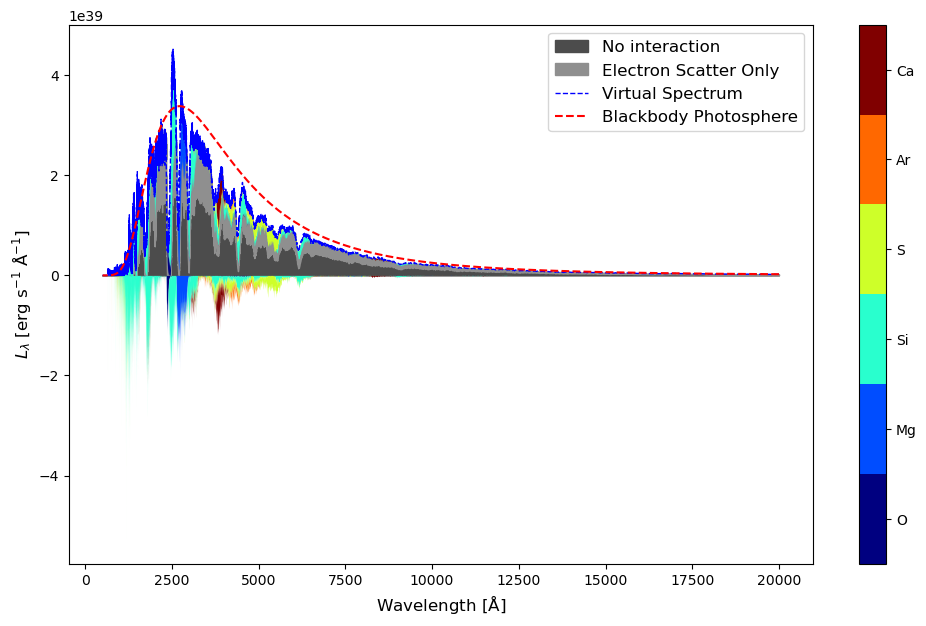

In [4]:
plotter.generate_plot_mpl()

# Abundance vs velocity

In [5]:
# Fetch velocities
shell_velocities = sim.model.v_inner.si
print(shell_velocities)

[11000000. 11450000. 11900000. 12350000. 12800000. 13250000. 13700000.
 14150000. 14600000. 15050000. 15500000. 15950000. 16400000. 16850000.
 17300000. 17750000. 18200000. 18650000. 19100000. 19550000.] m / s


In [6]:
# Fetch abundances
abundances = sim.plasma.abundance
abundances

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
atomic_number,,,,,,,,,,,,,,,,,,,,
8,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
12,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
14,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52
16,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
18,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
20,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


In [7]:
# Fetch shell densities
shell_densities = sim.model.homologous_density.density_0.si
print(shell_densities)

[1.97052717e+06 1.33603184e+04 1.01466582e+04 7.78662077e+03
 6.03344417e+03 4.71712224e+03 3.71894570e+03 2.95498192e+03
 2.36519135e+03 1.90615556e+03 1.54615391e+03 1.26178882e+03
 1.03564575e+03 8.54652716e+02 7.08918432e+02 5.90901467e+02
 4.94810562e+02 4.16168092e+02 3.51489643e+02 2.98046988e+02
 2.53691438e+02] kg / m3


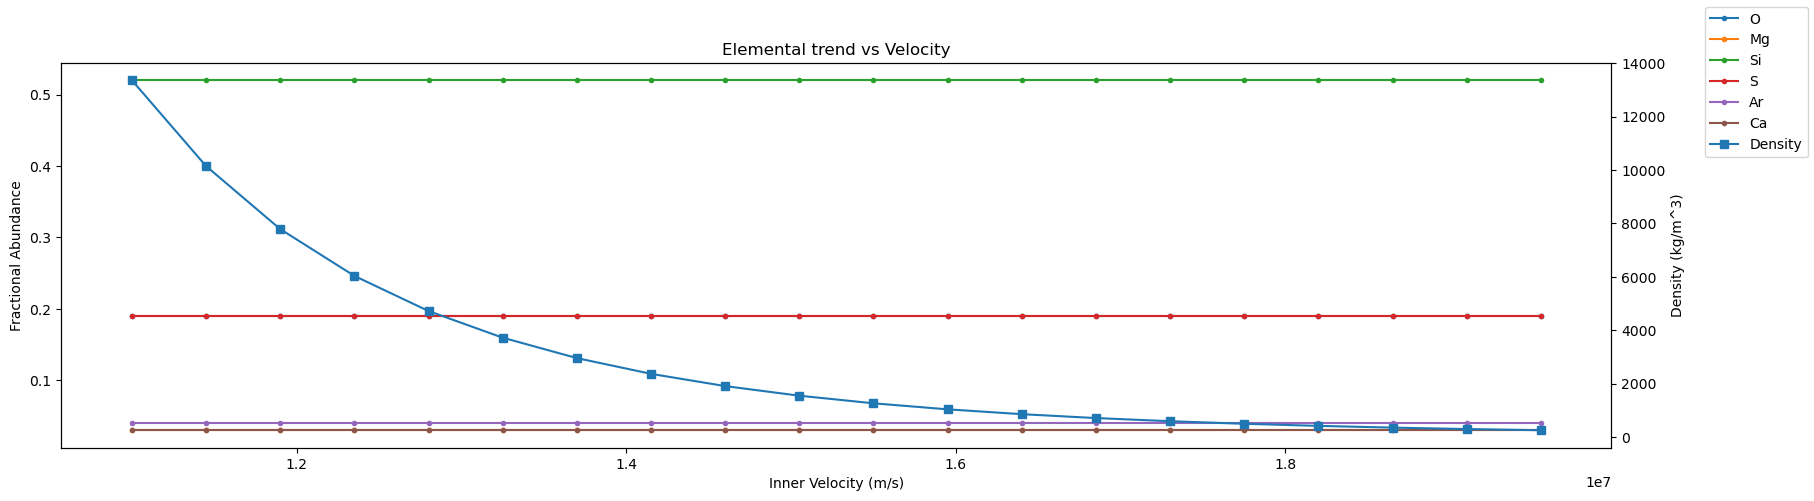

In [8]:
import matplotlib.pyplot as plt

# Plot fractional abudances
fig, abundance_axis = plt.subplots(figsize=(20, 5))

atom_data = sim.plasma.atomic_data.atom_data

for atomic_number in sim.plasma.selected_atoms:
    atom_abundance = abundances.loc[atomic_number]
    abundance_axis.plot(shell_velocities, atom_abundance, marker='.', label=atom_data.symbol.loc[atomic_number])

abundance_axis.set(title='Elemental trend vs Velocity', xlabel='Inner Velocity (m/s)', ylabel='Fractional Abundance')

density_axis = abundance_axis.twinx()
density_axis.plot(shell_velocities, shell_densities[1:], marker='s', label='Density')
density_axis.set(ylabel='Density (kg/m^3)')

_ = fig.legend()

## Visualization of abundances as a pir chart based on shell velocities

Each layer corresponds to a different shell

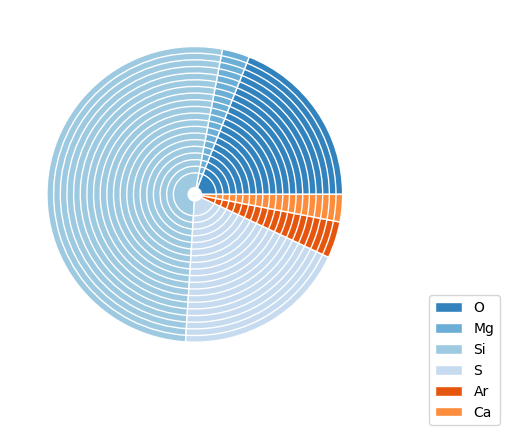

In [21]:
import numpy as np

fig, axis = plt.subplots()

elements = sim.plasma.selected_atoms
num_shells = len(shell_velocities)

cmap = plt.colormaps["tab20c"]
colors = cmap(np.arange(len(elements)))

for shell_idx, velocity in enumerate(shell_velocities):
    shell_abundances = abundances[shell_idx]
    pie = axis.pie(shell_abundances, radius=1-0.9*(shell_idx/num_shells), colors=colors, wedgeprops=dict(width=0.1, edgecolor='w'))


_ = axis.legend(pie[0], atom_data.symbol.loc[elements], bbox_to_anchor=(1,0), loc="lower right", bbox_transform=plt.gcf().transFigure)